# Lambda Model

Try to build a layer on top of old model so that we can feed it 3D images, without having to retrain it and then apply heatmaps in order to visualize what is happening.


In [1]:
import time
import glob, os, os.path
import h5py
import numpy as np

import matplotlib.pylab as plt

import os
os.environ['KERAS_BACKEND'] = 'theano'

%matplotlib inline
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Reshape, Input, Conv2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam
from keras.models import Model

pathFiles = "/home/atilla/Documents/DeepLearning/Model/"
os.chdir(pathFiles)

Using Theano backend.


# Load preivous trained model
We load the previous network to observe its artchitectural structure. We will copy the exact same structure when re-defining the model, just adding an extra layer.

In [85]:
# from keras.models import load_model
# model = load_model('/home/atilla/Documents/DeepLearning/Model/Compare/CNN/2017-05-10-21:16:50/V4_modelA2.hdf5')
# #model.load_weights('/home/atilla/Documents/DeepLearning/Model/weightsRGB.hdf5')
# model.load_weights('/home/atilla/Documents/DeepLearning/Model/Compare/CNN/2017-05-10-21:16:50/weights.hdf5')
# #model.summary()

In [16]:
from keras.models import load_model
model = load_model('/home/atilla/Documents/DeepLearning/Model/Compare/Simple/2017-05-16-10:53:41/V4_modelA2.hdf5')
#model.load_weights('/home/atilla/Documents/DeepLearning/Model/weightsRGB.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 30, 360, 2)        0         
_________________________________________________________________
zero_1 (ZeroPadding2D)       (None, 32, 362, 2)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 30, 360, 8)        152       
_________________________________________________________________
max_1 (MaxPooling2D)         (None, 15, 180, 8)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2764928   
_________________________________________________________________
drop_1 (Dropout)             (None, 128)               0         
__________

# Re-define Architecture of Model
In order to visualize the output of the different layers of the network, the visualization model needs to have a network with a 3D input image. 

What we do is to feed the network a 3D image, and then in the first layer take out the third channel, so in its essence nothing changes within the network. 

In [19]:


Bottom_dense=True
# 7. Define model architecture
#model = Sequential()
#inputs = Input(shape =(30,360,2), name = 'main_input' )
inputs = Input(shape =(30,360,3), name = 'main_input' )
x = Lambda(lambda x: x[:,:,:,:2], output_shape = (30,360,2))(inputs)
x =ZeroPadding2D((1,1), name ='zero_1', data_format = 'channels_last') (x)
x = Conv2D(8, (3, 3), activation='relu', name = 'conv_1')(x)
# x =ZeroPadding2D((1,1),  name = 'zero_2')(x)
# x =Conv2D(16, (3, 3), activation='relu', name = 'conv_2')(x)
x= MaxPooling2D((2,2), strides=(2,2), name = 'max_1')(x)



x =Flatten(name = 'flatten_1')(x)
if Bottom_dense == True :
    x =Dense(128, activation='relu', name = 'dense_1')(x)
    x=Dropout(0.5, name = 'drop_1')(x)
    x = Dense(128, activation='relu', name = 'dense_2')(x)
    x = Dropout(0.5, name = 'drop_2')(x)
#     x = Dense(32, activation='relu', name = 'dense_3')(x)
#     x = Dense(32, activation='relu', name = 'dense_5')(x)
    #x = Dropout(0.5, name = 'drop_3')(x)
    x=Dense(361, activation='softmax', name = 'dense_4')(x)
#     x=Dense(361, name = 'dense_3')(x)
#     x= Activation ('softmax',name = 'activation')(x)

model_new = Model(inputs, x, name= 'simple_model')
model_new.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-4), metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model_new.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 30, 360, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 30, 360, 2)        0         
_________________________________________________________________
zero_1 (ZeroPadding2D)       (None, 32, 362, 2)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 30, 360, 8)        152       
_________________________________________________________________
max_1 (MaxPooling2D)         (None, 15, 180, 8)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2764928   
__________

# Load weights into new model

In [11]:
#model_new.load_weights('/home/atilla/Documents/DeepLearning/Model/Compare/Simple/2017-05-16-00:19:54/weights.hdf5')
model_new.load_weights('/home/atilla/Documents/DeepLearning/Model/Compare/Simple/2017-05-16-10:53:41//weights.hdf5')

# Visualize dense/convolution layers

## Load keras visualization tools

In [12]:
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from keras import backend as K

from vis.visualization import visualize_cam
from vis.visualization import visualize_activation, get_num_filters

## Define what layer to visualize

In [39]:
layer_name = 'conv_1'
layer_idx = [idx for idx, layer in enumerate(model_new.layers) if layer.name == layer_name]

In [40]:
filter_num = 5
vis_images = [visualize_activation(model_new, layer_idx[0], filter_indices=idx, max_iter=500)
              for idx in [filter_num, filter_num, filter_num]]

# [3,3,3] creates 3 different images for output 3, not the three channels, puts it together. 
# meaning there are different images for each.. 


Working on filters: [5]
Working on filters: [5]
Working on filters: [5]


## Plot images

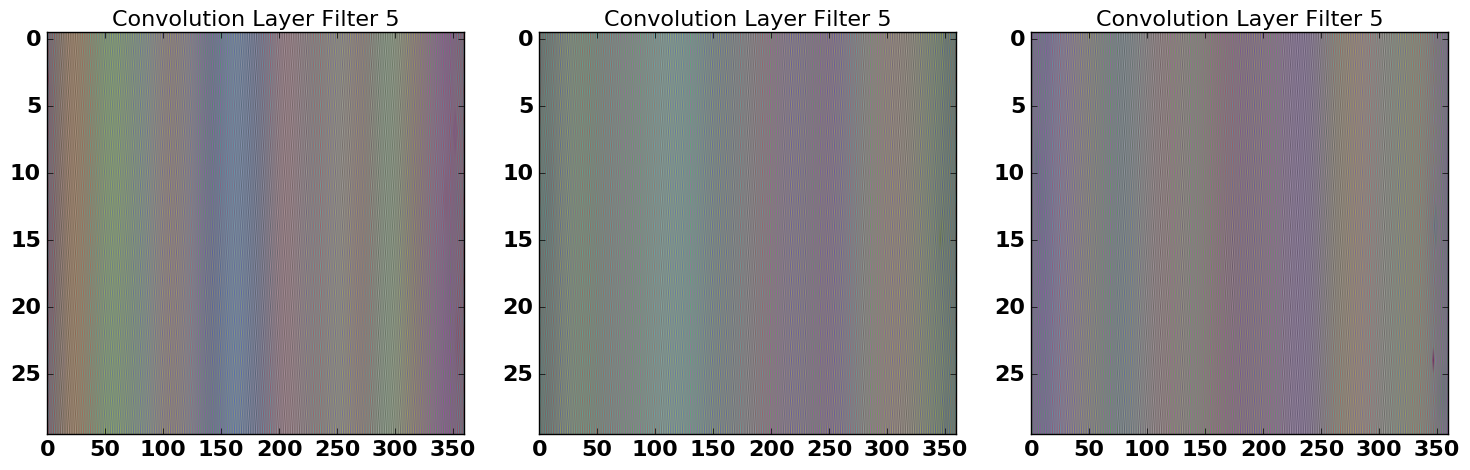

In [41]:
import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


fig, axarr = plt.subplots(figsize=[15, 5],
                          nrows=1, ncols=3)

for output_index in range(3):
     ax = axarr[output_index]
     ax.imshow(vis_images[output_index], aspect = 'auto')
     ax.set_title('Convolution Layer ' + 'Filter '+ str(5), fontsize = 16)
    
fig.tight_layout()


# Class activation maps (Working progress)

In [ ]:
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam

In [19]:
    def global_average_pooling(x):
        return K.mean(x, axis = (2, 3))
    
    def global_average_pooling_shape(input_shape):
        return input_shape[0:2]

## Redefine model 

to give a 3D input instead of 2D
and to use global average pooling instead of flattening

In [46]:
Bottom_dense=True
# 7. Define model architecture
#model = Sequential()
#inputs = Input(shape =(30,360,2), name = 'main_input' )
inputs = Input(shape =(30,360,3), name = 'main_input' )
x = Lambda(lambda x: x[:,:,:,:2], output_shape = (30,360,2))(inputs)
x =ZeroPadding2D((1,1), name ='zero_1', data_format = 'channels_last') (x)
x = Conv2D(16, (3, 3), activation='relu', name = 'conv_1', border_mode = 'full')(x)
# x =ZeroPadding2D((1,1),  name = 'zero_2')(x)
# x =Conv2D(16, (3, 3), activation='relu', name = 'conv_2')(x)
x= MaxPooling2D((2,2), strides=(2,2), name = 'max_1')(x)
#x =Flatten(name = 'flatten_1')(x)
x = Lambda(global_average_pooling, output_shape=global_average_pooling_shape)(x)

if Bottom_dense == True :
    x =Dense(128, activation='relu', name = 'dense_1')(x)
    x=Dropout(0.5, name = 'drop_1')(x)
    x = Dense(128, activation='relu', name = 'dense_2')(x)
    x = Dropout(0.5, name =x  'drop_2')(x)
#     x = Dense(32, activation='relu', name = 'dense_3')(x)
#     x = Dense(32, activation='relu', name = 'dense_5')(x)
    #x = Dropout(0.5, name = 'drop_3')(x)
    x=Dense(361, activation='softmax', name = 'dense_4')(x)
#     x=Dense(361, name = 'dense_3')(x)
#     x= Activation ('softmax',name = 'activation')(x)

model_new = Model(inputs, x, name= 'simple_model')
model_new.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-4), metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model_new.summary()


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="full", activation="relu", name="conv_1")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 30, 360, 3)        0         
_________________________________________________________________
lambda_12 (Lambda)           (None, 30, 360, 2)        0         
_________________________________________________________________
zero_1 (ZeroPadding2D)       (None, 32, 362, 2)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 34, 364, 16)       304       
_________________________________________________________________
max_1 (MaxPooling2D)         (None, 17, 182, 16)       0         
_________________________________________________________________
lambda_13 (Lambda)           (None, 17)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2304      
__________

## Load previously learned weights

In [25]:
model_new.load_weights('/home/atilla/Documents/DeepLearning/Model/Compare/Simple/2017-05-16-00:19:54/weights.hdf5')

## Load training data, images 

In [26]:
pathFiles = "/home/atilla/Documents/DeepLearning/Test/"
os.chdir(pathFiles)
file_name = 'V4_'
detail = 'compact_all_rand'
files = [file for file in glob.glob("*.hdf5") if file_name+detail in file]
print (files)
f = h5py.File(files[0])
dataset_x = f['data_x'][...]
dataset_y_raw = f['data_y_raw'][...]
length = len(dataset_y_raw)
length_train = int(round(0.8*length))
length_test = int(round(0.2*length))
#train_data_x = dataset_x[0:length_train]
train_data_y_raw = dataset_y_raw[0: length_train]
test_data_y_raw = dataset_y_raw[length_train: length_train+length_test+1]
train_data_y_deg = np.round(train_data_y_raw*180/np.pi+180)
test_data_y_deg = np.round(test_data_y_raw*180/np.pi+180)

['V4_compact_all_rand.hdf5']


## Reformat images
Add an extra channel of zeros, and reformat 

In [33]:
train_data_rgb =np.array([np.transpose(np.vstack(
                [dataset_x[1],np.zeros([1,dataset_x.shape[2], dataset_x.shape[3]])]),[1,2,0])])
img =train_data_rgb[0]

print(img.shape, train_data_rgb.shape)

(30, 360, 3) (1, 30, 360, 3)


In [34]:
width, height, _ = img.shape
img2 = np.array([np.transpose(np.float32(img), (2, 0, 1))])
img2.shape

(1, 3, 30, 360)

In [37]:
class_weights = model_new.layers[-1].get_weights()[0]
class_weights.shape

(128, 361)

In [66]:
 model_new.layers[-1].output

Softmax.0

# Create CAM 

Does not work for now because of dimensions mismatch, given the model has been trained differently.


In [84]:
#final_conv_layer = model_new.output("conv_1")
layer_name = 'conv_1'
layer_idx = [idx for idx, layer in enumerate (model_new.layers) if layer.name == layer_name][0]
final_conv_layer = model_new.layers[layer_idx].output
get_output = K.function([model_new.layers[0].input], \
                        [final_conv_layer])#, model_new.layers[-1].output])
[conv_outputs] = get_output([img2])
#get_output2  = K.function([model_new.layers[0].input], \
                        #[ model_new.layers[-1].output])
print(conv_outputs.shape, img2.shape, model_new.layers[0].input)
conv_outputs = conv_outputs[0, :, :, :]
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
target_class = 1
#for i, w in enumerate(class_weights[:, target_class]):
for i, w in enumerate(class_weights[:, target_class]):
    print (i, w)
    cam += w * conv_outputs[i, :, :]

(1, 7, 34, 16) (1, 3, 30, 360) dense_1/lambda_7/main_input
0 -0.222343
1 -0.653322
2 -0.397153
3 -0.161171
4 -0.171708
5 -0.0694249
6 -0.0231006
7 -0.0325012


IndexError: index 7 is out of bounds for axis 0 with size 7

In [81]:
print(class_weights.shape)
class_weights[:, target_class].shape

(128, 361)


(128,)